In [15]:
from __future__ import division
from math import log, exp, tan, atan, pi, ceil
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time
import scipy.spatial as spatial
from mayavi import mlab
# mlab.init_notebook()
import glob
from termcolor import colored
import re
import scipy.io as sio
from scipy.interpolate import InterpolatedUnivariateSpline
import shdom
import pandas as pd
from mpl_toolkits.axes_grid1 import AxesGrid

%matplotlib notebook

# Calculate plank radiation

constant factor should be 1395.703268036305


Text(1660.0, 0.4150895586749353, 'center value = 0.22')

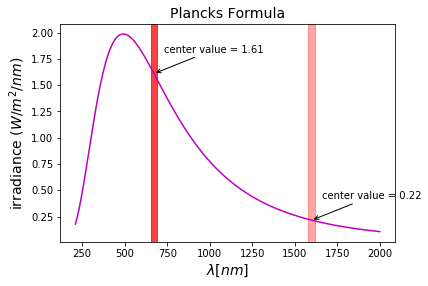

In [2]:
# ----------------------------------------------------
# ----------------------------------------------------# ----------------------------------------------------
# ----------------------------------------------------

def plank(llambda,T):
    h = 6.62607004e-34 # Planck constant
    c = 3.0e8
    k = 1.38064852e-23 # Boltzmann constant
    # https://en.wikipedia.org/wiki/Planck%27s_law
    a = 2.0*h*(c**2)
    b = (h*c)/(llambda*k*T)
    spectral_radiance = a/ ( (llambda**5) * (np.exp(b) - 1.0) )
    return spectral_radiance

start, end = 0.21, 2 # in micro meter [10^-6]
dlambda = 0.005
temp = 5900 #K
xspl = np.linspace(start, end, int((end - start) / dlambda)+1)

# dlambda = 0.005e-6
# wavelengths = np.arange(380e-9, 830e-9, dlambda) # my old 
wavelengths = xspl

# --------------------------------------------------------------------

# from https://socratic.org/questions/how-much-of-the-total-energy-that-leaves-the-sun-makes-it-to-earth-why
# Considering Sun to be situated at the centre of sphere whose radius is equal to the average distance between sun and earth
# which is 1.496×10^8km, erath radius is 6.371x10^3 km
# Solid angle subtended by the area of earth exposed to sun is SA

spectral_radiance_black_body = 6.8e-5*1e-9*plank(1e-6*wavelengths,temp) # units fo W/(m^2 nm) ,
# I am assuming a solid angle of 6.8e-5 steradian for the source (the solar disk).

plt.plot(wavelengths*1e3,spectral_radiance_black_body,color = 'm',label = 'black body at {}K'.format(temp))
plt.title("Plancks Formula", fontsize=14)
plt.xlabel("$\lambda [nm]$", fontsize=14)# sinse x axis is wavelengths*1e3
plt.ylabel("irradiance ($W/m^2/nm$)", fontsize=14)

B = np.trapz(spectral_radiance_black_body, x = xspl*1e3) # x is in nu 
print('constant factor should be {}'.format(B))

# example of plank at vis and swir:
vis_wavelength = 0.672 # micro meter.
swir_wavelength = 1.6 # micro meter.
# solar source:
VIS_L = 6.8e-5*1e-9*plank(1e-6*vis_wavelength,temp) # units fo W/(m^2 nm)
SWIR_L = 6.8e-5*1e-9*plank(1e-6*swir_wavelength,temp) # units fo W/(m^2 nm)
# highlighting regions
plt.axvspan(1e3*vis_wavelength-20,1e3*vis_wavelength+20, color='red', alpha=0.75)
plt.axvspan(1e3*swir_wavelength-20,1e3*swir_wavelength+20, color='red', alpha=0.35)

plt.annotate("center value = {:.2f}".format(VIS_L),xy=(1e3*vis_wavelength, VIS_L), xycoords='data',\
             xytext=(1e3*vis_wavelength+60, VIS_L+0.2), textcoords='data',arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
             
plt.annotate("center value = {:.2f}".format(SWIR_L),xy=(1e3*swir_wavelength, SWIR_L), xycoords='data',\
             xytext=(1e3*swir_wavelength+60, SWIR_L+0.2), textcoords='data',arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))

# Monochromatic Comparison

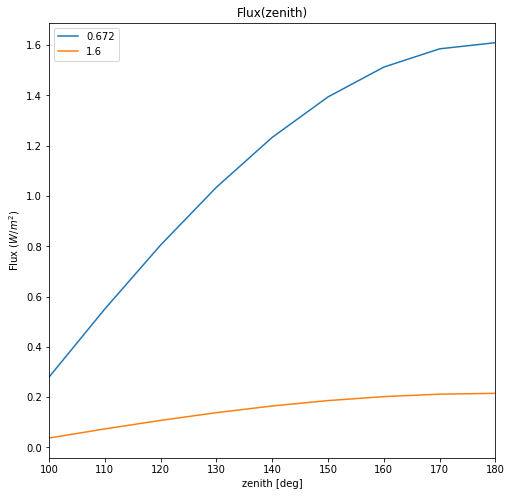

In [12]:
vis_wavelength = 0.672 # micro meter.
swir_wavelength = 1.6 # micro meter.
wavelength_for_table = [vis_wavelength, swir_wavelength]

# solar source:
N = 9
zenith = np.linspace(100,180,N) # Solar beam zenith angle in range (90,180]; Specified in degrees but immediately converted to the cosine of the angle (mu).
# Cosine of solar angle is cos(zenith).
# thus,
Cosain = np.cos(np.deg2rad((180-zenith)))
vis_L_TOA = 6.8e-5*1e-9*plank(1e-6*vis_wavelength,temp) # units fo W/(m^2)
swir_L_TOA = 6.8e-5*1e-9*plank(1e-6*swir_wavelength,temp) # units fo W/(m^2)

# L_TOA = 1 # units fo W/(m^2 nm)
# L_TOA = Cosain*L_TOA

vis_solar_fluxs = Cosain*vis_L_TOA
swir_solar_fluxs = Cosain*swir_L_TOA

"""
solar_flux: shdom probably doesn't scale the flux by the cosine but use the given flux as is/
"""
# if(isinstance(L_TOA, int)):
#     vis_solar_fluxs = np.tile(L_TOA,N)
#     swir_solar_fluxs = np.tile(L_TOA,N)
# else:
#     vis_solar_fluxs = L_TOA
#     swir_solar_fluxs = L_TOA
    
    
# create convinient pandas table:
data = [vis_solar_fluxs,swir_solar_fluxs]
df = pd.DataFrame(data=data, index=wavelength_for_table, columns=zenith)
ax = df.T.plot(figsize=(8, 8), title="Flux(zenith)")
ax.set_xlabel("zenith [deg]")
ax.set_ylabel("Flux ($W/m^2$)")

solar_fluxs = np.hstack((vis_solar_fluxs,swir_solar_fluxs))
zenith = np.tile(zenith,2)
wavelengths = np.hstack((np.tile(vis_wavelength,N),np.tile(swir_wavelength,N)))


Load Medium

In [5]:
vis_mie_base_path = '../vadim/mie_tables/polydisperse/Water_672nm.scat'
swir_mie_base_path = '../vadim/mie_tables/polydisperse/Water_1600nm.scat'
mie_table_paths = [vis_mie_base_path, swir_mie_base_path]

air_path = '../ancillary_data/AFGL_summer_mid_lat.txt' # Path to csv file which contains temperature measurements
air_num_points = 20 # Number of altitude grid points for the air volume
air_max_alt = 5 # in km ,Maximum altitude for the air volume

# Generate multi-spectral scatterers for both droplets and air molecules
droplets = shdom.MicrophysicalScatterer()
droplets.load_from_csv('../synthetic_cloud_fields/jpl_les/rico32x37x26.txt', veff=0.1)
# droplets.load_from_csv('ZeroAtm100x100x10.txt', veff=0.1)

air = shdom.MultispectralScatterer()

# Rayleigh scattering for air molecules
df = pd.read_csv(air_path, comment='#', sep=' ')
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, air_num_points, air_max_alt))

for wavelength, table_path in zip(wavelength_for_table, mie_table_paths):  
    # Molecular Rayleigh scattering
    rayleigh = shdom.Rayleigh(wavelength)
    rayleigh.set_profile(temperature_profile.resample(air_grid))
    air.add_scatterer(rayleigh.get_scatterer())
    
    # Droplet Mie scattering
    mie = shdom.MiePolydisperse()
    mie.read_table(table_path)
    droplets.add_mie(mie)
    
    
# Generate an atmospheric medium with both scatterers
atmospheric_grid = droplets.grid + air.grid
atmosphere = shdom.Medium(atmospheric_grid)
atmosphere.add_scatterer(droplets, name='cloud')
atmosphere.add_scatterer(air, name='air')


Reading mie table from file: ../vadim/mie_tables/polydisperse/Water_672nm.scat
Reading mie table from file: ../vadim/mie_tables/polydisperse/Water_1600nm.scat


# Set RTE solver

In [6]:
# Generate a solver array for a multispectral solution
rte_solvers = shdom.RteSolverArray()
"""
Parallel solving of all solvers.
        
        Main solver routine. This routine is comprised of two parts:
          1. Initialization (init_solution method), optional
          2. Parallel solution iterations (solution_iterations method followed by update_solution_arguments method)
"""
numerical_params = shdom.NumericalParameters(num_mu_bins=16,num_phi_bins=32,
                                                 split_accuracy=0.1,max_total_mb=500000.0)

for wavelength,angle,solar_flux in zip(wavelengths,zenith,solar_fluxs):
    scene_params = shdom.SceneParameters(
        wavelength=wavelength,
        surface=shdom.LambertianSurface(albedo=0.05),
        source=shdom.SolarSource(azimuth=0, zenith=angle,flux=solar_flux) # flux=solar_flux
    ) 
    rte_solver = shdom.RteSolver(scene_params, numerical_params)
    rte_solver.set_medium(atmosphere)
    rte_solvers.add_solver(rte_solver)

--- the wantmem variable before REDUCE is 720270120.0, memory usage is 2881080480.0
--- the wantmem variable after REDUCE is 720270120.0, memory usage is 2881080480.0
--- the wantmem variable after REDUCE in Mib is 3021.03184539648
--- The memory is being used per voxel is 78495.0
---  SYSTEM MAX SIZE is 9223372036854775807
--- MAXIG	max number of internal grid points is 183520
--- MAXIC	max number of grid cells, between 1 and 2 times grid points is 275280
--- MAXIV	max words for source function and radiance arrays; needed size is average spherical harmonic truncation times number of grid points is 234905600
--- MAXIDO	max words for temporary discrete ordinate azimuthal array; needed size is max azimuths times number of grid points. is 5872640
--- MAXIR	The RADIANCE defined by RADIANCE(MAXIV+MAXIG). MAXIR is 235089120
--- NLM    spherical harmonic terms is 256
--- ADAPTIVE GRID FACTOR    ratio of the max number of internal grid points to the number of base grid points is 5.0
---  CELL_

--- the wantmem variable before REDUCE is 720270120.0, memory usage is 2881080480.0
--- the wantmem variable after REDUCE is 720270120.0, memory usage is 2881080480.0
--- the wantmem variable after REDUCE in Mib is 3021.03184539648
--- The memory is being used per voxel is 78495.0
---  SYSTEM MAX SIZE is 9223372036854775807
--- MAXIG	max number of internal grid points is 183520
--- MAXIC	max number of grid cells, between 1 and 2 times grid points is 275280
--- MAXIV	max words for source function and radiance arrays; needed size is average spherical harmonic truncation times number of grid points is 234905600
--- MAXIDO	max words for temporary discrete ordinate azimuthal array; needed size is max azimuths times number of grid points. is 5872640
--- MAXIR	The RADIANCE defined by RADIANCE(MAXIV+MAXIG). MAXIR is 235089120
--- NLM    spherical harmonic terms is 256
--- ADAPTIVE GRID FACTOR    ratio of the max number of internal grid points to the number of base grid points is 5.0
---  CELL_

Set multi-view Setup

In [7]:
# orbit altitude:
Rsat = 500 # km
from shdom import CloudCT_setup

# -----------------------------------------------
# ---------Calculate camera footprint at nadir --
# -----------------------------------------------

dx = atmospheric_grid.dx
dy = atmospheric_grid.dy

nz = atmospheric_grid.nz
nx = atmospheric_grid.nx
ny = atmospheric_grid.ny

Lx = atmospheric_grid.bounding_box.xmax - atmospheric_grid.bounding_box.xmin
Ly = atmospheric_grid.bounding_box.ymax - atmospheric_grid.bounding_box.ymin
Lz = atmospheric_grid.bounding_box.zmax - atmospheric_grid.bounding_box.zmin
L = max(Lx,Ly)
Lz_droplets = droplets.grid.bounding_box.zmax - droplets.grid.bounding_box.zmin
dz = Lz_droplets/nz

#USED FOV, RESOLUTION and SAT_LOOKATS:
PIXEL_FOOTPRINT = 0.02 # km
fov = 2*np.rad2deg(np.arctan(0.5*L/(Rsat)))
cny = int(np.floor(L/PIXEL_FOOTPRINT))
cnx = int(np.floor(L/PIXEL_FOOTPRINT))

CENTER_OF_MEDIUM_BOTTOM = [0.5*nx*dx , 0.5*ny*dy , 0]

# Somtimes it is more convinent to use wide fov to see the whole cloud
# from all the view points. so the FOV is aslo tuned:
IFTUNE_CAM = True
# --- TUNE FOV, CNY,CNX:
if(IFTUNE_CAM):
    L = 1.5*L
    fov = 2*np.rad2deg(np.arctan(0.5*L/(Rsat)))
    cny = int(np.floor(L/PIXEL_FOOTPRINT))
    cnx = int(np.floor(L/PIXEL_FOOTPRINT))    

print(20*"-")
print(20*"-")
print(20*"-")

print("CAMERA intrinsics summary")
print("fov = {}[deg], cnx = {}[pixels],cny ={}[pixels]".format(fov,cnx,cny))

print(20*"-")
print(20*"-")
print(20*"-")

print("Medium summary")
print("nx = {}, ny = {},nz ={}".format(nx,ny,nz))
print("dx = {}, dy = {},dz ={}".format(dx,dy,dz))
print("Lx = {}, Ly = {},Lz ={}".format(Lx,Ly,Lz))
x_min = atmospheric_grid.bounding_box.xmin
x_max = atmospheric_grid.bounding_box.xmax

y_min = atmospheric_grid.bounding_box.ymin
y_max = atmospheric_grid.bounding_box.ymax

z_min = atmospheric_grid.bounding_box.zmin
z_max = atmospheric_grid.bounding_box.zmax 
print("xmin = {}, ymin = {},zmin ={}".format(x_min,y_min,z_min))
print("xmax = {}, ymax = {},zmax ={}".format(x_max,y_max,z_max))

print(20*"-")
print(20*"-")
print(20*"-")
# ---------------------------------------------------------------
# ---------------CREATE THE SETUP----------------------------
# ---------------------------------------------------------------
SATS_NUMBER = 10
VISSETUP = True
# not for all the mediums the CENTER_OF_MEDIUM_BOTTOM is a good place to lookat.
# tuning is applied by the variavle LOOKAT.
LOOKAT = CENTER_OF_MEDIUM_BOTTOM
LOOKAT[2] = 0.5*nx*dz # tuning

SAT_LOOKATS = np.array(SATS_NUMBER*LOOKAT).reshape(-1,3)       

# create CloudCT setup:
CloudCT_VIEWS = CloudCT_setup.Create(\
    SATS_NUMBER = SATS_NUMBER,ORBIT_ALTITUDE = Rsat, \
    CAM_FOV = fov, CAM_RES = (cnx,cny), SAT_LOOKATS = SAT_LOOKATS, VISSETUP = VISSETUP)


--------------------
--------------------
--------------------
CAMERA intrinsics summary
fov = 0.12375884054856795[deg], cnx = 54[pixels],cny =54[pixels]
--------------------
--------------------
--------------------
Medium summary
nx = 32, ny = 37,nz =31
dx = 0.019999999552965164, dy = 0.019999999552965164,dz =0.03225806451612903
Lx = 0.6200000047683716, Ly = 0.7200000286102295,Lz =20.0
xmin = 0.0, ymin = 0.0,zmin =0.0
xmax = 0.6200000047683716, ymax = 0.7200000286102295,zmax =20.0
--------------------
--------------------
--------------------


Solve RTE

In [8]:
"""
Solve the Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure (shdomsub1.f).
The outputs are the source function (J) and radiance field (I) which are stored in 
the shdom.RteSolver object. These are subsequently used for the rendering of an image.
"""
rte_solvers.solve(maxiter=100)

RENDER IMAGES

In [9]:
"""
Each projection in CloudCT_VIEWS is A Perspective projection (pinhole camera).
"""
camera = shdom.Camera(shdom.RadianceSensor(), CloudCT_VIEWS)
# render all:
images = camera.render(rte_solvers, n_jobs=20)
# len(images) = 10, each image.shape is (nx,ny,N*2)
"""
The elements of a list images relates to view point.
Then, there are N chanels which relates to zenith at the vis_wavelength and 
N chanels which relates to zenith at the swir_wavelength.
"""

'\nThe elements of a list images relates to view point.\nThen, there are N chanels which relates to zenith at the vis_wavelength and \nN chanels which relates to zenith at the swir_wavelength.\n'

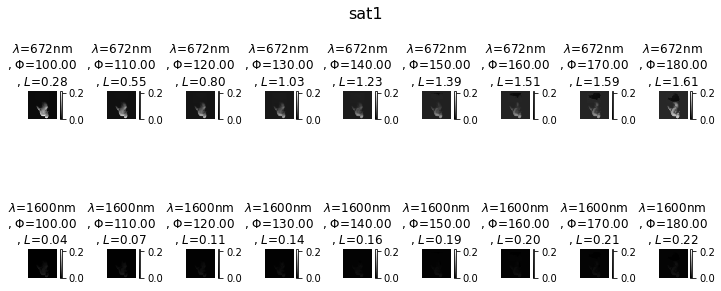

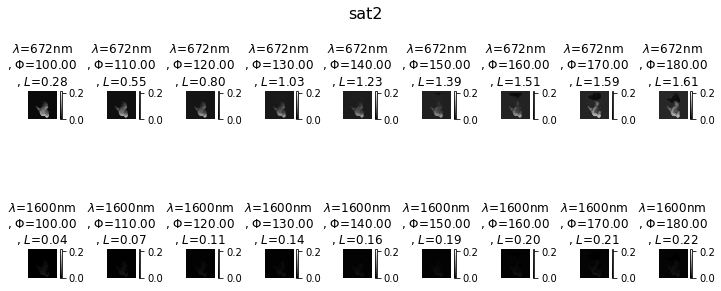

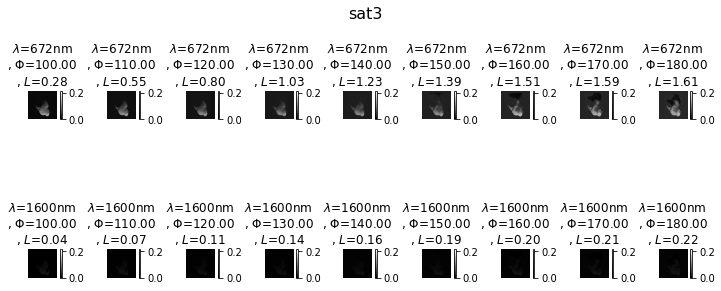

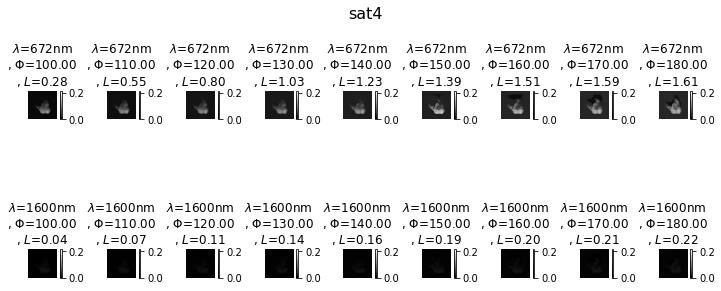

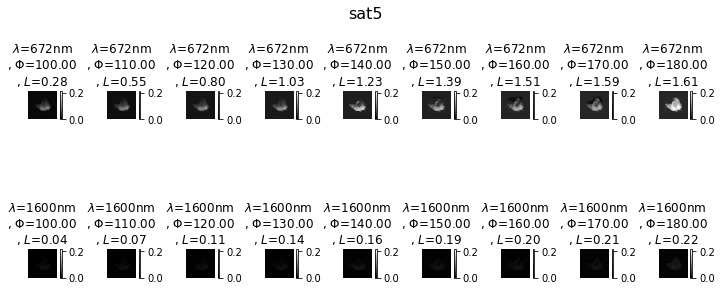

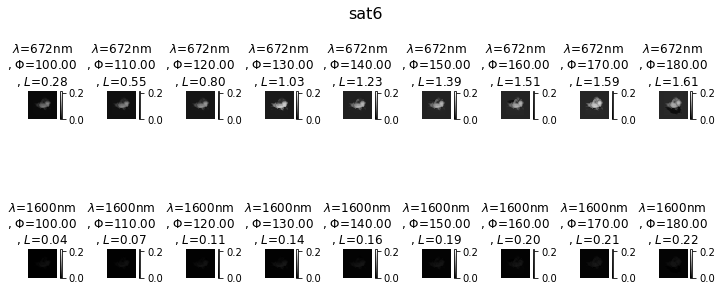

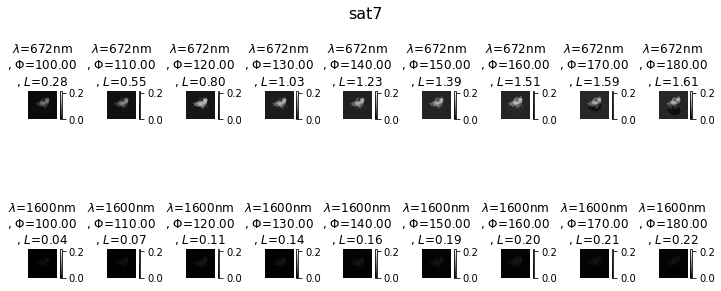

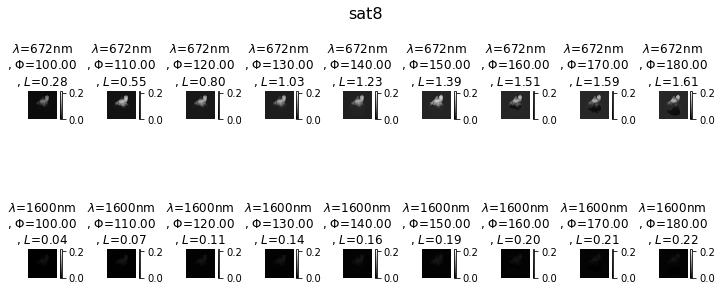

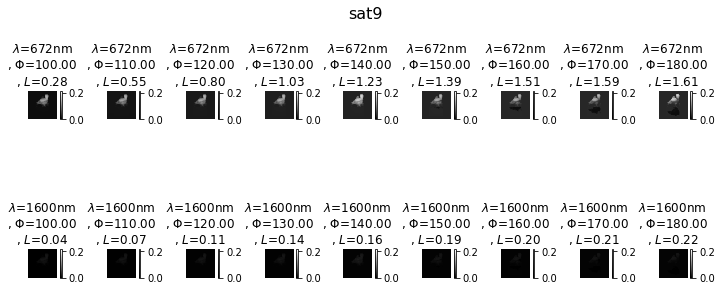

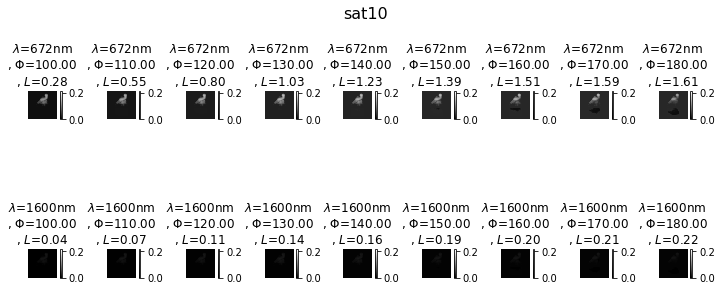

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
#interactive plotting in separate window
# matplotlib.use('tkAgg')
# import matplotlib.pyplot as plt
# %matplotlib qt5

projection_names = CloudCT_VIEWS.projection_names
# calculate images maximum:
images_array = np.array(images)
MAXI = images_array.max()
    
for imagemultichannel, name in zip(images, projection_names):
#     if name == 'sat6':
    if True:
        fig, axarr = plt.subplots(2, N, figsize=(10, 5))
        ax = axarr.ravel()

        for index , (wavelength,angle,solar_flux) in enumerate(zip(wavelengths,zenith,solar_fluxs)):

            title = "$\lambda$={}nm\n, $\Phi$={:.2f}\n, $L$={:.2f}".format(int(1e3*wavelength),angle,solar_flux)
            im = ax[index].imshow(imagemultichannel[:,:,index],cmap='gray',vmin=0, vmax=MAXI)
            ax[index].axis('off')
            divider = make_axes_locatable(ax[index])
            cax = divider.append_axes('right', size='5%', pad=0.05)        
            fig.colorbar(im, cax=cax, orientation='vertical')

            ax[index].set_title(title)

        fig.suptitle(name, size=16)
        fig.tight_layout()
    #     fig.subplots_adjust(top=0.88)


    


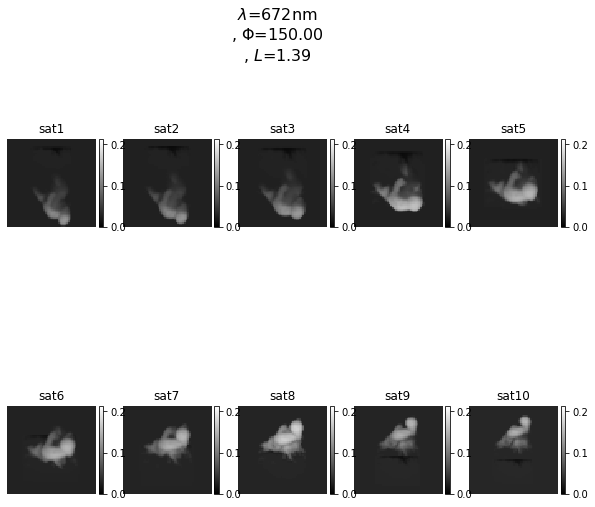

In [13]:
WI = 0 # wavelength index
AI = 5 # zenith index
ind_CHANNEL = WI*N + AI

fig, axarr = plt.subplots(2, int(np.ceil(SATS_NUMBER/2)), figsize=(10, 9))
ax = axarr.ravel()
    
for index, (imagemultichannel, name) in enumerate(zip(images, projection_names)):
        
    title = "$\lambda$={}nm\n, $\Phi$={:.2f}\n, $L$={:.2f}".format(int(1e3*wavelength_for_table[WI]),zenith[AI],df.iloc[WI][zenith[AI]])
    im = ax[index].imshow(imagemultichannel[:,:,ind_CHANNEL],cmap='gray',vmin=0, vmax=MAXI)
    ax[index].axis('off')
    divider = make_axes_locatable(ax[index])
    cax = divider.append_axes('right', size='5%', pad=0.05)        
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax[index].set_title(name)

    fig.suptitle(title, size=16)
#     fig.tight_layout()
#     fig.subplots_adjust(top=0.88)

    
    file_name = '{}_w_{}_phi_{:.0f}_L_{:.0f}e-2'.format(name,int(1e3*wavelength_for_table[WI]),zenith[AI],100*df.iloc[WI][zenith[AI]])+'.mat'
    sio.savemat(file_name, {'img':imagemultichannel[:,:,ind_CHANNEL]})
            
    
plt.show()

<IPython.core.display.Javascript object>


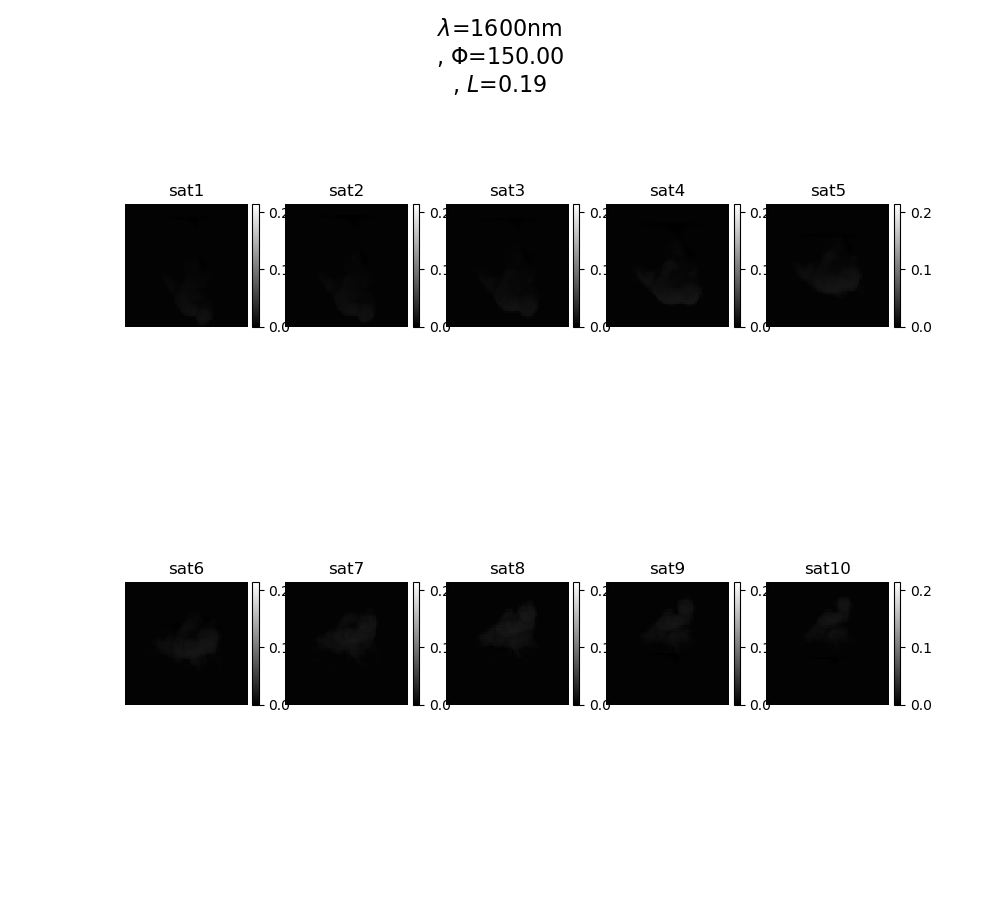

In [51]:
WI = 1 # wavelength index
AI = 5 # zenith index
ind_CHANNEL = WI*N + AI

fig, axarr = plt.subplots(2, int(np.ceil(SATS_NUMBER/2)), figsize=(10, 9))
ax = axarr.ravel()
    
for index, (imagemultichannel, name) in enumerate(zip(images, projection_names)):
        
    title = "$\lambda$={}nm\n, $\Phi$={:.2f}\n, $L$={:.2f}".format(int(1e3*wavelength_for_table[WI]),zenith[AI],df.iloc[WI][zenith[AI]])
    im = ax[index].imshow(imagemultichannel[:,:,ind_CHANNEL],cmap='gray',vmin=0, vmax=MAXI)
    ax[index].axis('off')
    divider = make_axes_locatable(ax[index])
    cax = divider.append_axes('right', size='5%', pad=0.05)        
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax[index].set_title(name)

    fig.suptitle(title, size=16)
#     fig.tight_layout()
#     fig.subplots_adjust(top=0.88)

    
    
plt.show()

In [98]:
.

array([0.672, 0.672, 0.672, 0.672, 0.672, 0.672, 0.672, 0.672, 0.672,
       1.6  , 1.6  , 1.6  , 1.6  , 1.6  , 1.6  , 1.6  , 1.6  , 1.6  ])

In [54]:
df.iloc[WI][zenith[AI]]

0.18627302190127756

In [15]:
k=1

In [18]:
isinstance(k, int)

True

<IPython.core.display.Javascript object>


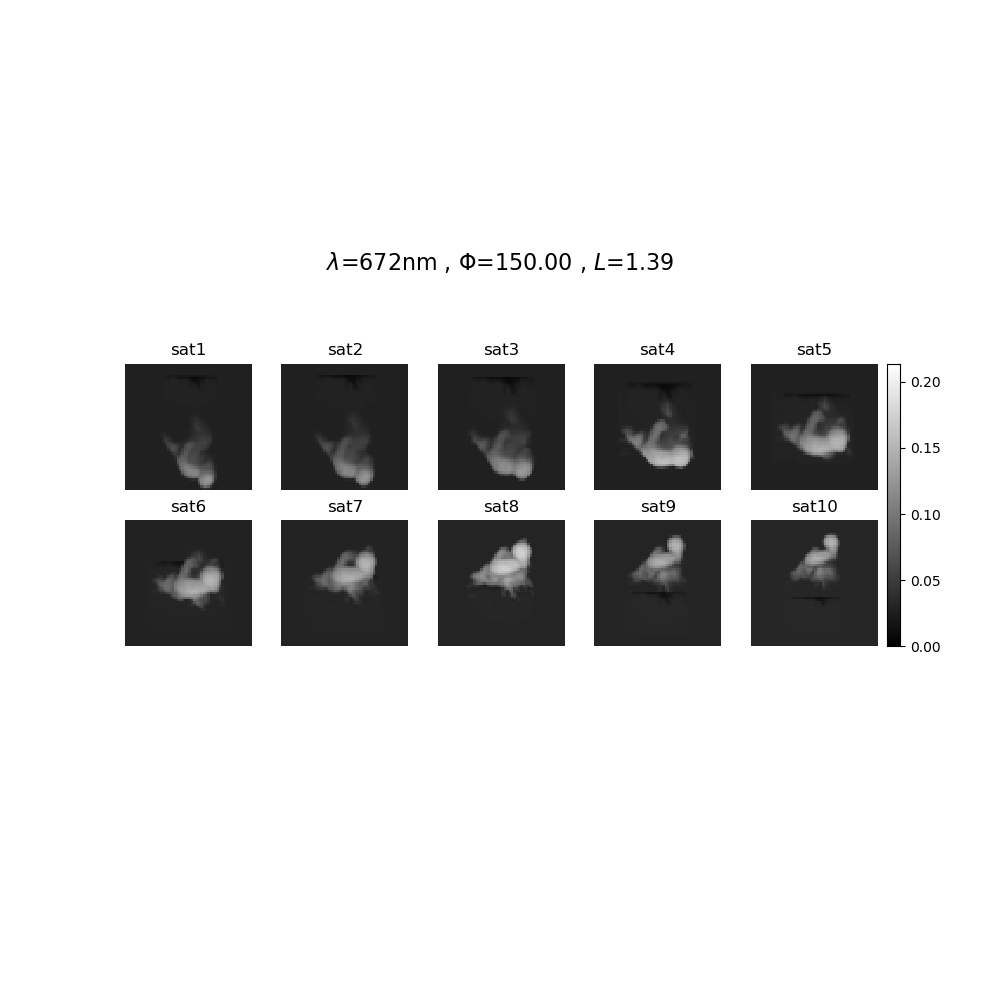

In [33]:
WI = 0 # wavelength index
AI = 5 # zenith index
ind_CHANNEL = WI*N + AI

fig = plt.figure(figsize=(10, 10))
grid = AxesGrid(fig, 111,
                nrows_ncols=(2, int(np.ceil(SATS_NUMBER/2))),
                axes_pad=0.3,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

for index, (ax, imagemultichannel, name) in enumerate(zip(grid, images, projection_names)):
        
    title = "$\lambda$={}nm , $\Phi$={:.2f} , $L$={:.2f}".format(int(1e3*wavelength_for_table[WI]),zenith[AI],df.iloc[WI][zenith[AI]])
    im = ax.imshow(imagemultichannel[:,:,ind_CHANNEL],cmap='gray',vmin=0, vmax=MAXI)
    ax.axis('off')
    ax.set_title(name)
    
    file_name = '{}_w_{}_phi_{:.0f}_L_{:.0f}e-2'.format(name,int(1e3*wavelength_for_table[WI]),zenith[AI],100*df.iloc[WI][zenith[AI]])+'.mat'
    sio.savemat(file_name, {'img':imagemultichannel[:,:,ind_CHANNEL]})

cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

fig.suptitle(title, size=16,y=0.75)    
plt.show()

In [60]:
MAXI

0.21363874